# Expression Evaluation (User Defined Functions)

So far we have seen that ironArray has support for evaluating expressions that are passedas strings or as simple Python statements.  There is another, more flexible way for evaluating expressions called User Defined Functions, or UDFs for short.

UDFs are small functions that can be expressed in a simple subset of Python.  These functions are then passed to the internal LLVM compiler in ironArray and a binary specific and optimized for the local machine is generated.  This binary is optimized for the CPU and in addition, it will make use of the [Intel MKL library](https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html) for accelerating transcendental functions.

Let's see how this works.

In [1]:
%load_ext memprofiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iarray as ia

In [8]:
%%time
precip1 = ia.load("precip1.iarr")
precip2 = ia.load("precip2.iarr")
precip3 = ia.load("precip3.iarr")

CPU times: user 57.2 ms, sys: 242 ms, total: 300 ms
Wall time: 679 ms


Now, let's define a simple function that computes the mean for this data:

In [3]:
from iarray.udf import jit, Array, float32

@jit()
def mean(out: Array(float32, 3),
         p1: Array(float32, 3),
         p2: Array(float32, 3),
         p3: Array(float32, 3)) -> int:

    l = p1.window_shape[0]
    m = p1.window_shape[1]
    n = p1.window_shape[2]

    for i in range(l):
        for j in range(m):
            for k in range(n):
                value = p1[i,j,k] + p2[i,j,k] + p3[i,j,k]
                out[i,j,k] = value / 3

    return 0

and create the ironArray expression from this User Defined Function with:

In [4]:
%%time
precip_expr = ia.expr_from_udf(mean, [precip1, precip2, precip3])

CPU times: user 23.3 ms, sys: 3.96 ms, total: 27.2 ms
Wall time: 26.6 ms


As can be seen, converting the user defined function into a native ironArray expression is pretty fast.  And as always, in order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
%%mprof_run iarray-mean
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

memprofiler: used 3519.80 MiB RAM (peak of 3519.80 MiB) in 3.3559 s, total RAM usage 4571.38 MiB


Let's compare this time with the evaluation via a regular lazy expression:

In [6]:
precip_expr2 = (precip1 + precip2 + precip3) / 3

In [7]:
%%mprof_run iarray-mean2
precip_mean2 = precip_expr2.eval()
precip_mean2

<IArray (720, 721, 1440) np.float32>

memprofiler: used 1524.80 MiB RAM (peak of 1557.42 MiB) in 3.1394 s, total RAM usage 6096.05 MiB


Ok, so the times are very close.  It turns out that UDFs compile and execute in ironArray using the very same LLVM machinery, which explains times being similar.  It is up to the user to use one or the other depending on the needs.

TODO:
* Use the transcendental functions
* Compare with numba

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of the computational engine inside ironArray:

In [2]:

import math

@jit()
def trans(out: Array(float32, 3),
          p1: Array(float32, 3),
          p2: Array(float32, 3),
          p3: Array(float32, 3)) -> int:

    l = p1.window_shape[0]
    m = p1.window_shape[1]
    n = p1.window_shape[2]

    for i in range(l):
        for j in range(m):
            for k in range(n):
                value = math.sin(p1[i,j,k]) * math.sin(p2[i,j,k]) + math.cos(p2[i,j,k])
                value *= math.tan(p1[i,j,k])
                value += math.cosh(p3[i,j,k]) * 2
                out[i,j,k] = value

    return 0

TypeError: cannot store double to float*: mismatching types

In [ ]:
%%time
precip_expr = ia.expr_from_udf(trans, [precip1, precip2, precip3])

In [8]:
%%mprof_run iarray-trans
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

memprofiler: used 674.53 MiB RAM (peak of 676.89 MiB) in 1.3874 s, total RAM usage 13221.93 MiB


In this case we see that the overhead of using transcendental functions is pretty low compared with plain arithmetic operations (sum, rest, mult, division...). Let's compare this against NumPy:

In [9]:
%%mprof_run np_trans
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

memprofiler: used 2851.63 MiB RAM (peak of 8554.86 MiB) in 9.7094 s, total RAM usage 16073.58 MiB


Ok, this is really slow, but this is kind of expected, as ironArray comes with support for evaluating transcendental functions via MKL, as well other optimizations courtesy of the internal LLVM compiler.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [10]:
%%mprof_run _
precip_expr = (precip1 + precip2 + precip3) / 3
precip_mean = precip_expr.eval()
precip_mean

AttributeError: The memory profile label is incorrect!

Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray methods:

In [11]:
%%mprof_run _
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# You can also use the next idiom, which is not as close to NumPy, but a hair more concise
#lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2
lazy_result = lazy_expr.eval()
lazy_result

<IArray (720, 721, 1440) np.float32>

memprofiler: used 568.72 MiB RAM (peak of 571.09 MiB) in 1.4722 s, total RAM usage 17034.63 MiB


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

## Resource consumption

As a summary, let's do a plot on the speed for the different kind of computations:

In [12]:
%mprof_plot ia_mean np_mean -t "Mean computation"

As we can see iron_array not only makes computations fast, but specially requiring much less memory.

And let's see the resouce consumption for the transcendental expression:

In [13]:
%mprof_plot ia_trans np_trans -t "Transcendental expression"

The picture is quite different for the transcendental expression.  This time ironArray is way faster while consuming *much* less memory.

### In-deep memory consumption analysis

Memory efficiency is critical for ironArray, so let's dig a bit more on the pattern of the memory used for both types of computations.

Measuring memory consumption of a Python code in a notebook is challenging because the Python interpreter may decide to free memory at any time, so it is always better to isolate the code that we want to measure in a standalone script and make use of the `mprof` module that comes with the nice `memory_profiler` package.

Let's start with ironArray:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


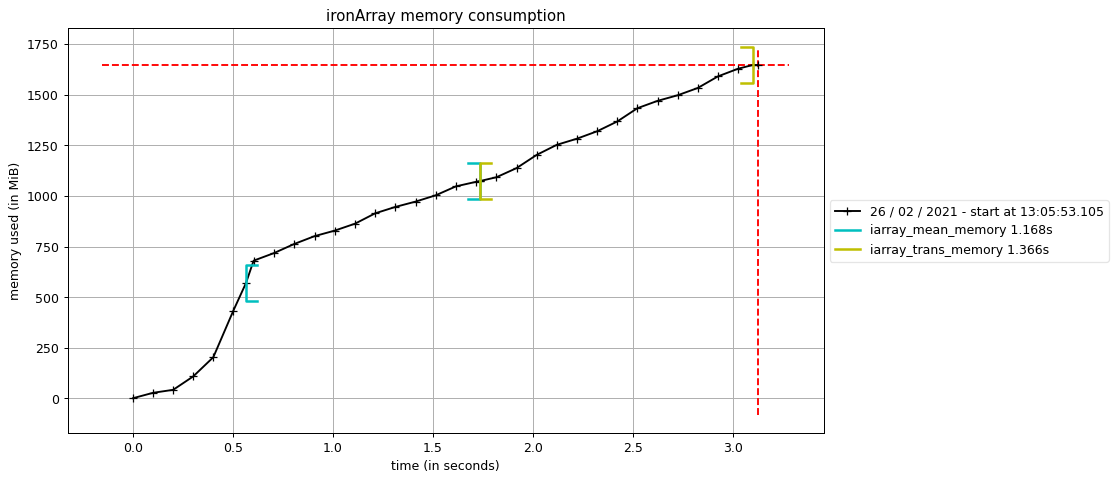

In [14]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

The first part of the plot is the loading process of the 3 months of precipitation arrays from disk.  This process stops when the 600 MB mark is reached, meaning that the (compressed) data takes that storage in memory.  The part between blue brackets corresponds to the actual mean computation and ~500 MB were needed to host the mean array.  Finally, the yellow brackets show the computation of the transcendental expression (around 700 MB more).  In the end, ironArray has needed a grand total of 1.6 GB so as to evaluate the *two* expresions.

Now, let's see what is the memory consumption for NumPy:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


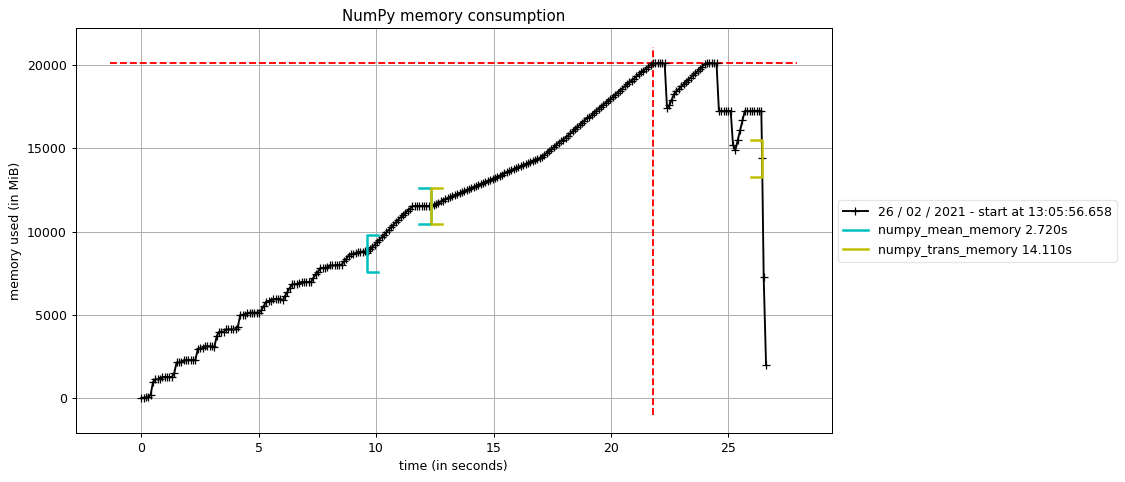

In [15]:
%rm numpy_mean_memory.dat
%run -m mprof run -o numpy_mean_memory.dat numpy_mean_memory.py
%run -m mprof plot numpy_mean_memory.dat -t "NumPy memory consumption"

In this case, the first part of the plot stops around 8.5 GB (the size of the uncompressed dataset).  The section between blue brackets is where the mean is computed.  In this case, NumPy is well optimized, as it does not seem to use big temporaries (and this is part of the reason on why its computation speed is pretty good).  However, the section for the transcendental evaluation (yellow brackets) shows a more complex pattern, with 2 peaks before reaching the end of the computation.  These peaks clearly correspond to the big temporaries that are needed during the evaluation.  In the end, NumPy has needed around 20 GB so as to evaluate the two expressions.  In comparison, ironArray consumes more than 10x less memory for the same task.

In general, this means that ironArray can perform operations requiring less memory than using non-compressed arrays, while using a similar time (or much less, like e.g. expressions requiring large temporaries or intermediate function evaluation).

Finally, when we want to minimize the amount of memory during computations, ironArray can also perform evaluations on arrays that are resident on disk (aka out-of-core) in a completely transparent way.  This is the subject of the 'on-disk' counterpart of this tutorial.

## Optimization Tips

Even if ironArray has been very competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here, even at the expense of using more memory.

If you remember from the tutorial on reductions, we already reached to kind of 'optimal' chunks for reductions,
so let's reuse this:

In [16]:
%%mprof_run _
ia_precip_opt = ia.open("precip-3m-optimal.iarr")
ia_precip_opt.info

type                : IArray
shape               : (3, 720, 721, 1440)
chunkshape          : (1, 360, 128, 1440)
blockshape          : (1, 8, 8, 720)
memprofiler: used 0.00 MiB RAM (peak of 0.00 MiB) in 0.0040 s, total RAM usage 17039.86 MiB


In this case, the chunks and blocks were considerably larger.  Let's reuse these and see how this effects to our computations.  For this, we are going to recreate the operands but with the setup for speed and optimal chunks and blocks:

In [17]:
%%mprof_run _
ia.set_config(favor=ia.Favors.SPEED, chunkshape=(360, 128, 1440), blockshape=(8, 8, 720))
precip1_sp = ia_precip_opt[0].copy()
precip2_sp = ia_precip_opt[1].copy()
precip3_sp = ia_precip_opt[2].copy()

memprofiler: used 1747.14 MiB RAM (peak of 2757.41 MiB) in 9.7788 s, total RAM usage 18787.00 MiB


In [18]:
%%mprof_run ia_mean_speed
precip_mean = (precip1_sp + precip2_sp + precip3_sp) / 3
precip_mean_speed = precip_mean.eval()

memprofiler: used 1039.92 MiB RAM (peak of 1039.93 MiB) in 0.6272 s, total RAM usage 19826.93 MiB


Now, this is almost 2x faster than our original computation with ironArray and even more than NumPy:

In [19]:
%mprof_plot ia_mean ia_mean_speed np_mean -t "Mean computation"

Of course having more speed has been at the cost of using more memory.  In general, you will normally have to choose between using more memory or speed.  The nice thing about ironArray is that it lets you choosing what you favor very easily.

Finally, let's suppose that we want to favor compression ratio for the output, instead of speed.  We can achieve that by asking for just 3 decimals of precision; it should help to favor compression ratio via `ia.Favors.CRATIO` too:

In [20]:
%%mprof_run ia_mean_cratio

precip_mean = (precip1_sp + precip2_sp + precip3_sp) / 3
# eval but just keep 3 digits in precision (10 bits in mantissa)
precip_mean_cratio = precip_mean.eval(fp_mantissa_bits=10, favor=ia.Favors.CRATIO)

memprofiler: used 783.83 MiB RAM (peak of 783.83 MiB) in 0.5972 s, total RAM usage 20610.94 MiB


In [21]:
%mprof_plot ia_mean ia_mean_speed ia_mean_cratio np_mean -t "Mean computation"

Here we saved some good couple of hundreds of MBs for performing the operation and hosting the new output.  As you see, ironArray offers you a wide range of functionality to fight memory scarcity, while keeping execution times very reasonable.